# Load the dataset and clean it  
### Author: Francesca Naretto


In [1]:
#load the adult dataset
import pandas as pd
adult = pd.read_csv('./datasets/adult.data', delimiter=",", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week', 'native-country', 'label'])

In [2]:
#visualize the structure of the dataset
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#a descrption of the dataset
adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
#check if there is any null value
adult.isnull().values.any()

False

### Discretize the categorical variables
We can discretize the categorical variables and then use them for the classification task. NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN)

In [5]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['relationship', 'race', 'sex', 'occupation', 'marital-status', 'workclass', 'native-country', 'label']
adult = discretize_data(adult, variables)

In [7]:
#drop the categorical variables since we don't need them anymore 
adult.drop(columns=['relationship', 'race', 'sex', 'occupation', 'marital-status', 'workclass', 'native-country', 'label', 'education'], axis=1,inplace=True)

In [8]:
#the resulting dataset
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,relationship_num,race_num,sex_num,occupation_num,marital-status_num,workclass_num,native-country_num,label_num
0,39,77516,13,2174,0,40,1,4,1,1,4,7,39,0
1,50,83311,13,0,0,13,0,4,1,4,2,6,39,0
2,38,215646,9,0,0,40,1,4,1,6,0,4,39,0
3,53,234721,7,0,0,40,0,2,1,6,2,4,39,0
4,28,338409,13,0,0,40,5,2,0,10,2,4,5,0


# Classfication with decision tree
To classify, we first need to split the dataset into train and test dataset.
We can do so using train_test_split, in this case we select a stratified split (we want to maintain the same ratio among the classes).

In [9]:
from sklearn.model_selection import train_test_split
label = adult.pop('label_num')

# use stratify to keep distribution the same between the splits
train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify =label, test_size=0.30)

Define the Decision Tree, in this case the classifier one (we have a discrete label), and then fit it. Every model has its parameters to set, for the Decision Tree you should select the criterion, the splitter and some parameters regarding the shape of the tree to build. Refer to the official documentation to see the details.

In [10]:
#define a decision tree and fit it
# controlo max depth and min smaple to avoid overfitting

from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [11]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['<=50', '>50'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
# Image(graph.create_png())

After the fitting, we can use the tree to predict.  

In [12]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix
After having fitted the model, it is important to understand how the model is performing. To evaluate the goodness of the model, we can compute several metrics, such as accuracy, precision and recall. Pay attention to the fact that not all the metrics are meaningfull, depending on the imbalance in the dataset.

In [13]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8694278694278694
Accuracy test set  0.8525949431876344
Precision train set  0.8653914189600913
Recall train set  0.8694278694278694
F1 score train set  0.8664440927503592
Support train set  (array([0.8986588, 0.7605225]), array([0.93324857, 0.66824558]), array([0.91562713, 0.71140419]), array([17303,  5489], dtype=int64))


In [14]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['<=50', '>50']))

In [15]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

        <=50       0.89      0.92      0.91      7417
         >50       0.72      0.62      0.67      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.85      0.85      9769



To better evaluate the performance of our model, we use the cross-validation. We can do so exploiting a function from sklearn. Then, we can compute the score array for test/train scores on each cv split as well as the time for fitting/scoring the estimator on the train set for each cv split.

In [16]:
from sklearn.model_selection import cross_validate
import statistics 
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.04221971829732259
Score time  0.0
Test score  0.8481046032946256
Train score  0.8731353085881377


Another kind of evaluation is the confusion matrix, in which we can clearly see the number of true positive, false positive, true negative, false negative.

In [17]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[6859,  558],
       [ 882, 1470]], dtype=int64)

C:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


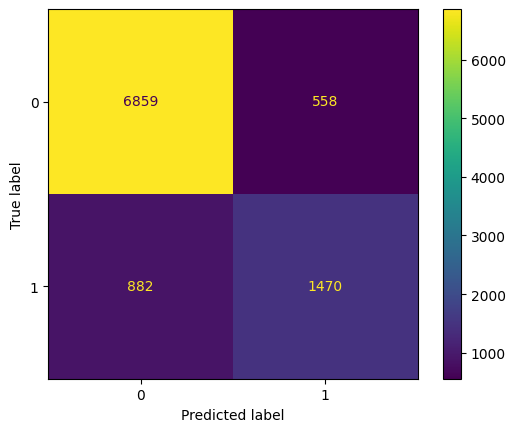

In [18]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

Another visualization of the behaviour of the model is to exploit scatter plots. We can plot the data points, w.r.t. 2 or 3 features, coloring the points depending on the labels: first, with the original labels, then the predicted labels.

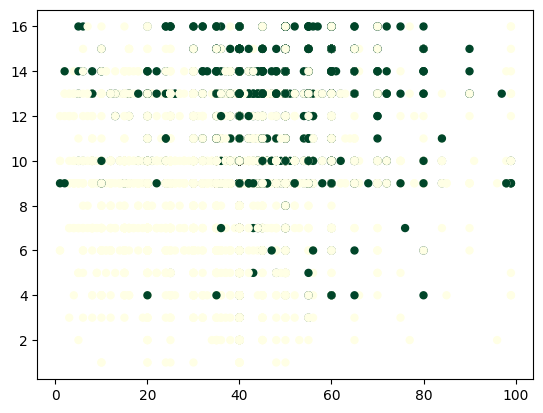

In [19]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 5].values, test_set.iloc[:, 2].values, c=test_label.values, s=25, cmap='YlGn');

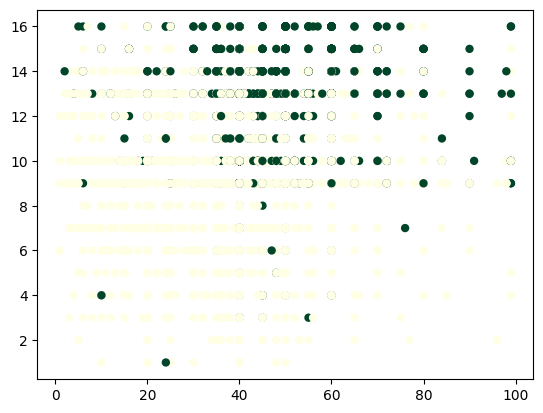

In [20]:
#predicted labels
plt.scatter(test_set.iloc[:, 5].values, test_set.iloc[:, 2].values, c=test_pred_dt, s=25, cmap='YlGn');

# Classification with Naive Bayes
Bayes’ Theorem provides a way that we can calculate the probability of a piece of data belonging to a given class, given our prior knowledge. Bayes’ Theorem is stated as:

P(class|data) = (P(data|class) * P(class)) / P(data)
Where P(class|data) is the probability of class given the provided data.

In [21]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [22]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

        <=50       0.81      0.95      0.88      7417
         >50       0.67      0.30      0.42      2352

    accuracy                           0.80      9769
   macro avg       0.74      0.63      0.65      9769
weighted avg       0.78      0.80      0.77      9769



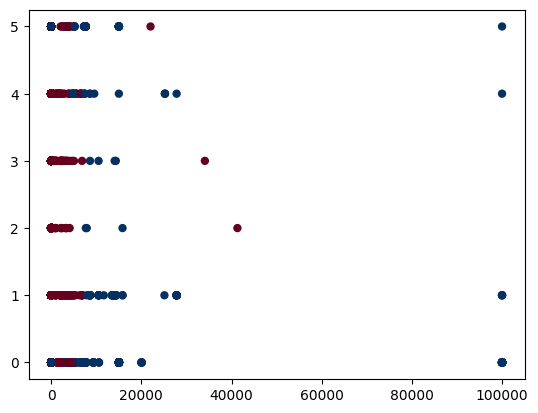

In [23]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_label.values, s=25, cmap='RdBu');

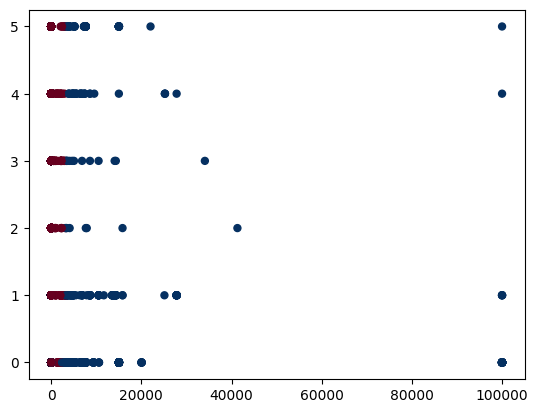

In [24]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_pred_gnb, s=25, cmap='RdBu');

# Classification with Random Forest
The Random Forest is an ensemble method composed by Decision Trees. Hence, there are several parameters to set: about the trees and the ensemble method, such as bootstrap and number of estimators. The performance of this model greatly depends on the paramters set. Refer to the official documentation to see the complete set of parameters.

In [25]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=3,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [26]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [27]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

        <=50       0.86      0.96      0.90      7417
         >50       0.78      0.49      0.60      2352

    accuracy                           0.84      9769
   macro avg       0.82      0.72      0.75      9769
weighted avg       0.84      0.84      0.83      9769



### Grid search for parameter setting 
For improving the performance of our model, we can run a grid search: we can select the values we want to test for each parameter, and then run the grid search, which evaluates the best set of values parameters.

In [28]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EB0B4E920>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EB0B4FE20>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EB0B4E890>},
                   scoring=make_scorer(accuracy_score))

In [29]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': {0: 0.3, 1: 0.7}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 13, 'min_samples_leaf': 45, 'min_samples_split': 35}
Mean and std of this setting  0.8007637276020573 0.008526574819446714


In [30]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=8,
                             max_depth=6, 
                             min_samples_split=32,
                             min_samples_leaf=10,
                             bootstrap=True)
# if I have a huge dataset consider all the data may be not so good, so we can set bootstrap = true
rf = rf.fit(train_set, train_label)

In [31]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [32]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

        <=50       0.87      0.96      0.91      7417
         >50       0.79      0.53      0.64      2352

    accuracy                           0.85      9769
   macro avg       0.83      0.74      0.77      9769
weighted avg       0.85      0.85      0.84      9769



#### We can try to improve the performance by using class weights

In [33]:
class_weights = {0: 0.35, 1:0.65}
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=8,
                             max_depth=6, 
                             min_samples_split=32,
                             min_samples_leaf=10,
                             bootstrap=False,
                             class_weight= class_weights) 
rf = rf.fit(train_set, train_label)

In [34]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

#### In this way we obtain a better performance in terms of recall for the class 1, but we loose a bit on the recall of class 0.

In [35]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_rf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.93      0.84      0.88      7417
         >50       0.61      0.80      0.69      2352

    accuracy                           0.83      9769
   macro avg       0.77      0.82      0.79      9769
weighted avg       0.85      0.83      0.83      9769



# AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [37]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.88      0.94      0.91      7417
         >50       0.77      0.59      0.67      2352

    accuracy                           0.86      9769
   macro avg       0.82      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



Adaboost has many parameters, we can select the base classifier, which can be a DecisionTree, a Logistic Regression and so on, we can select the number of estimators and the learning rate.

In [38]:
base = tree.DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(base_estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(train_set, train_label)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=200)

In [39]:
test_pred_clf = clf.predict(test_set)
print(classification_report(test_label, 
                            test_pred_clf, 
                            target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.89      0.94      0.91      7417
         >50       0.77      0.63      0.69      2352

    accuracy                           0.87      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769



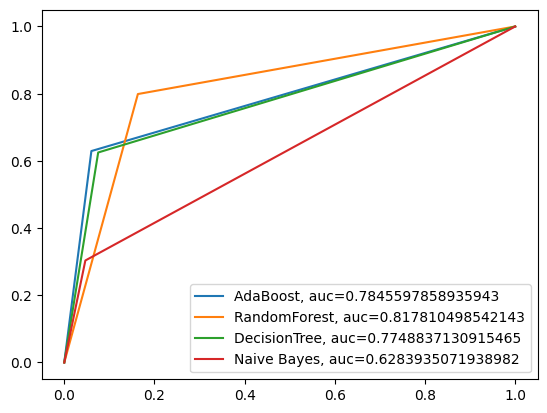

In [40]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_clf)
auc = metrics.roc_auc_score(test_label, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

# Classification with rules based classifier

In [ ]:
# DA FARE!! RIVEDERE IL NOTEBOOK

# Classification with Neural Networks

In [41]:
import tensorflow as tf

In [42]:
adult.shape

(32561, 13)

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 13)),       # just one record
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')]                          # binary classification
)

In [45]:
model.compile(optimizer='adamax', loss='mse', metrics=['accuracy']) # consider also f1 score in the metrics

In [46]:
# first normalize the data!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_set)
train_set = scaler.transform(train_set)
test_set = scaler.transform(test_set)

In [47]:
train_set

array([[-0.77923657,  2.26750106, -0.42537201, ..., -1.72551236,
         0.08345169,  0.2917815 ],
       [ 2.51443583, -0.11430849, -0.42537201, ..., -0.40080616,
        -2.65623993,  0.2917815 ],
       [-0.48646569, -0.83373843,  1.13388637, ...,  0.92390005,
         0.08345169,  0.2917815 ],
       ...,
       [-0.26688753, -0.7303707 , -0.42537201, ...,  2.24860625,
         0.08345169,  0.2917815 ],
       [-1.36477833,  0.46288935, -0.42537201, ...,  0.92390005,
         0.08345169, -3.65210544],
       [ 0.31865423,  0.52490998, -0.42537201, ..., -0.40080616,
         0.08345169, -1.36210657]])

In [48]:
train_set.shape

(22792, 13)

In [49]:
train_label.shape

(22792,)

In [50]:
# reshape the data
import numpy as np
x_train = np.reshape(train_set, (22792, 1, 13))
y_train = np.asarray(train_label).astype('float32').reshape((-1, 1))

In [60]:
# train the model
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs, batch_size=512, validation_split=0.2)

Epoch 1/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.8209 - val_loss: 0.1312 - val_accuracy: 0.8149
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1279 - accuracy: 0.8214 - val_loss: 0.1304 - val_accuracy: 0.8155
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1272 - accuracy: 0.8224 - val_loss: 0.1297 - val_accuracy: 0.8155
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1266 - accuracy: 0.8224 - val_loss: 0.1290 - val_accuracy: 0.8182
Epoch 5/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1260 - accuracy: 0.8229 - val_loss: 0.1285 - val_accuracy: 0.8168
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1255 - accuracy: 0.8239 - val_loss: 0.1280 - val_accuracy: 0.8173
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1251 - accuracy: 0.8249 - val_loss: 0.1276 - val_accuracy: 0.8182
Epoch 8/100
3

In [61]:
x_test = np.reshape(test_set, (len(test_set), 1, 13))
pred = (model.predict(x_test) > 0.5).astype('int32')

306/306 [==============================] - 1s 2ms/step


In [62]:
pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [63]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))
report_scores(test_label, pred)

              precision    recall  f1-score   support

        <=50       0.86      0.94      0.90      7417
         >50       0.73      0.51      0.60      2352

    accuracy                           0.84      9769
   macro avg       0.80      0.72      0.75      9769
weighted avg       0.83      0.84      0.83      9769



In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 13)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                448       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


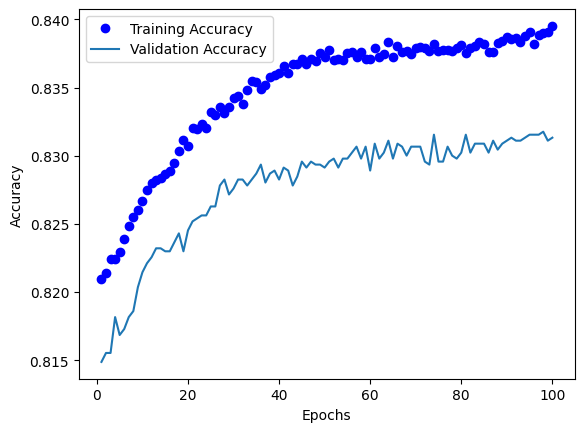

In [67]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [68]:
# add dropout

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 13)),       # just one record
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')]                          # binary classification
)

In [69]:
model.compile(optimizer='adamax', loss='mse', metrics=['accuracy']) # consider also f1 score in the metrics

In [70]:
# train the model
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs, batch_size=512, validation_split=0.2)

Epoch 1/100
36/36 [==============================] - 2s 11ms/step - loss: 0.4267 - accuracy: 0.2434 - val_loss: 0.3030 - val_accuracy: 0.2485
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.2486 - accuracy: 0.5474 - val_loss: 0.2033 - val_accuracy: 0.7515
Epoch 3/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1965 - accuracy: 0.7409 - val_loss: 0.1839 - val_accuracy: 0.7515
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1839 - accuracy: 0.7567 - val_loss: 0.1781 - val_accuracy: 0.7515
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 0.1779 - accuracy: 0.7591 - val_loss: 0.1749 - val_accuracy: 0.7515
Epoch 6/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1746 - accuracy: 0.7607 - val_loss: 0.1722 - val_accuracy: 0.7515
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1723 - accuracy: 0.7617 - val_loss: 0.1697 - val_accuracy: 0.7515
Epoch 8/100


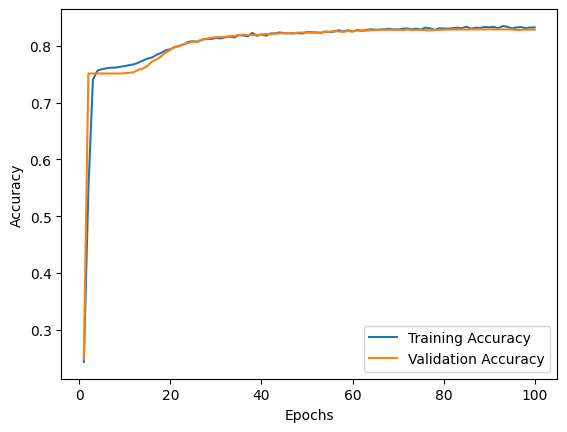

In [72]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# no overfitting!

# Classification on unbalanced data

In [83]:
adult = pd.read_csv('./datasets/adult_imbalanced.csv')
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29817 entries, 0 to 29816
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Unnamed: 0          29817 non-null  int64
 1   age                 29817 non-null  int64
 2   fnlwgt              29817 non-null  int64
 3   education-num       29817 non-null  int64
 4   capital-gain        29817 non-null  int64
 5   capital-loss        29817 non-null  int64
 6   hours-per-week      29817 non-null  int64
 7   relationship_num    29817 non-null  int64
 8   race_num            29817 non-null  int64
 9   sex_num             29817 non-null  int64
 10  occupation_num      29817 non-null  int64
 11  marital-status_num  29817 non-null  int64
 12  workclass_num       29817 non-null  int64
 13  native-country_num  29817 non-null  int64
 14  label_num           29817 non-null  int64
dtypes: int64(15)
memory usage: 3.4 MB


Let's check how data are distributed

In [84]:
adult['label_num'].value_counts(True) #unblanced!

0    0.829057
1    0.170943
Name: label_num, dtype: float64

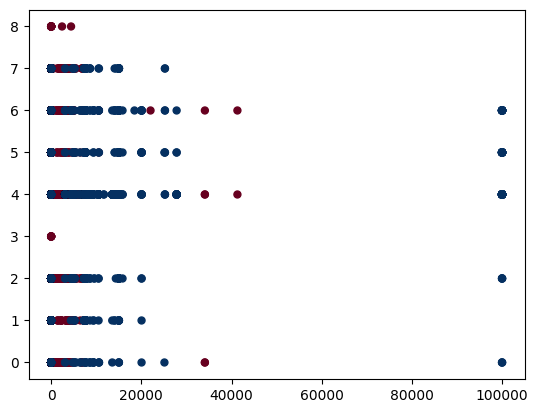

In [86]:
# see the unbalancing
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.scatter(adult['capital-gain'].values, adult['workclass_num'].values, c=adult['label_num'].values, s=25, cmap='RdBu');

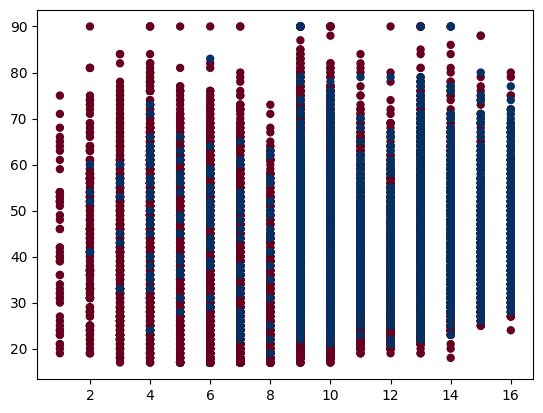

In [87]:
plt.scatter(adult['education-num'].values, adult['age'].values, c=adult['label_num'].values, s=25, cmap='RdBu');

# Classification

In [88]:
from sklearn.model_selection import train_test_split
label = adult.pop('Unnamed: 0')
train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify=label, test_size=0.30)


train_set.head()

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Decision Tree

In [ ]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=10,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [ ]:
from sklearn.metrics import classification_report
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

The recall for class >50 is 0.33. This is due to the fact that the dataset is imablanced. Let’s try a different classifier.

In [ ]:
plt.scatter(test_set['capital-gain'].values, test_set['workclass_num'].values, c=test_label.values, s=25, cmap='RdBu');

In [ ]:
plt.scatter(test_set['capital-gain'].values, test_set['workclass_num'].values, c=test_pred, s=25, cmap='RdBu');

we can oversampling or undersampling

In [ ]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
adult_o, label_o = oversample.fit_resample(train_set, train_label)


In [ ]:
label_o.value_counts(True)

In [ ]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=10,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(adult_o, label_o)

In [ ]:
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
adult_u, label_u = undersample.fit_resample(train_set, train_label)

In [ ]:
label_u.value_counts(True)

In [ ]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=10,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(adult_u, label_u)

In [ ]:
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

In [ ]:
# combine the sampler
oversample = RandomOverSampler(sampling_strategy=0.60)
adult_o_o, label_o_o = oversample.fit_resample(train_set, train_label)
undersample = RandomUnderSampler(sampling_strategy=0.70)
adult_o_u, label_o_u = undersample.fit_resample(adult_o_o, label_o_o)

In [ ]:
label_o_u.value_counts(True)

In [ ]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=10,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(adult_o_u, label_o_u)

In [ ]:
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

### SMOTE algorithm

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.3)
adult_s, label_s = oversample.fit_resample(train_set, train_label)

In [ ]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=10,
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(adult_o_u, label_o_u)

In [ ]:
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))